In [1]:
%matplotlib inline
import numpy as np
import modisco
from __future__ import print_function, division
import theano
print("Theano version:",theano.__version__)

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29



Couldn't import dot_parser, loading of dot files will not be possible.
Theano version: 0.9.0


Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5005)


## Grab the input data

In [2]:
!./grab_data.sh

File task0importancescores.npy exists already
File task0hypimpscores.npy exists already
File sequences.txt exists already


### Functions for one-hot encoding sequences

In [3]:
def one_hot_encode_along_channel_axis(sequence):
    #theano dim ordering, uses row axis for one-hot
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task. In this example, there is only one task

In [4]:
task_to_scores = {'task0': np.load("task0importancescores.npy")}
task_to_hyp_scores = {'task0': np.load("task0hypimpscores.npy")}
onehot_data = np.array([one_hot_encode_along_channel_axis(x.rstrip())
                        for x in open("sequences.txt")])

Double check by plotting

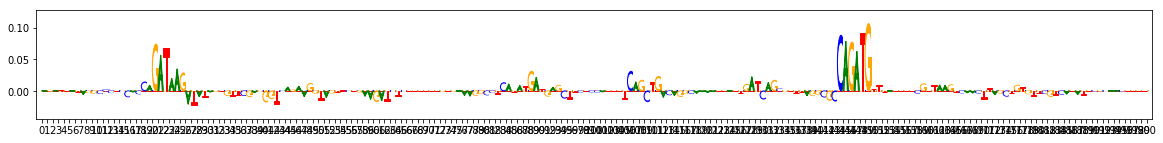

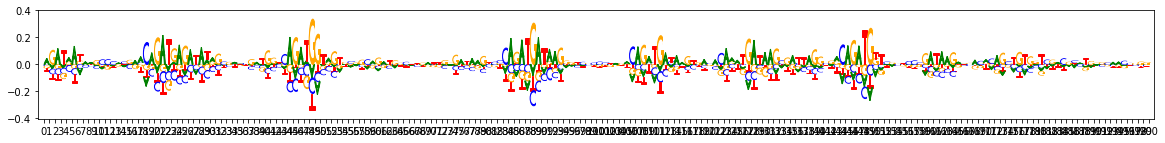

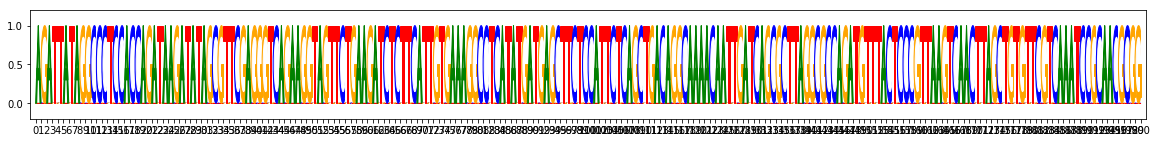

In [5]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0])
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0])
viz_sequence.plot_weights(onehot_data[0])

## Run TF-MoDISco

TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there is just one task, there are only 2 possible metaclusters: +1 for the task and -1 for the task. The -1 metacluster does not turn up any motifs after noise filtering, but the +1 metacluster produces two motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:
- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central `trim_to_window_size` bp with the highest importance. `trim_to_window_size` is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by `initial_flank_to_add`. This is set to 3 rather than the default of 10.
- The `final_min_cluster_size` is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 50 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine on more modern GPUs than the one in my 4-year-old macbook.

On task task0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Got 18358 coords
Computing thresholds
Bandwidth calculated: 0.0317520946264267


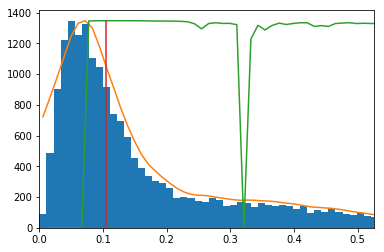

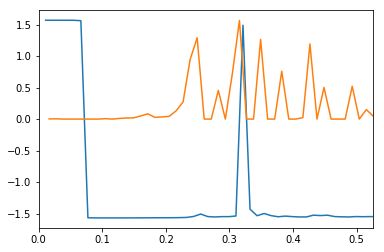

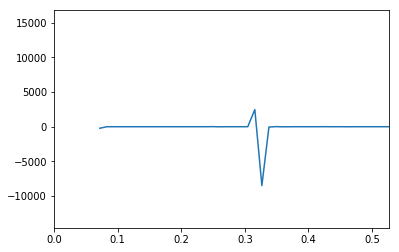

Computed threshold 0.10523871302604676
9118 coords remaining after thresholding
After resolving overlaps, got 9118 seqlets
2 activity patterns with support >= 200 out of 3 possible patterns
Metacluster sizes:  [5710, 3408]
Idx to activities:  {0: '1', 1: '-1'}
On metacluster 1
Metacluster size 3408
Relevant tasks:  ('task0',)
Relevant signs:  (-1,)
(Round 1) num seqlets: 3408
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 2.57 s
Starting affinity matrix computations
Normalization computed in 0.03 s
Cosine similarity mat computed in 0.14 s
Normalization computed in 0.02 s
Cosine similarity mat computed in 0.15 s
Finished affinity matrix computations in 0.3 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.38 s
(Round 1) Computing affinity matrix on nearest neighbors
Launching nearest neighbors affmat calculation job
Job completed in: 25.53 s
Launching nearest neighbors affmat

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    2.5s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    3.0s finished


Louvain completed 200 runs in 5.92633390427 seconds
Wrote graph to binary file in 1.08425712585 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.759657
After 2 runs, maximum modularity is Q = 0.768125
After 7 runs, maximum modularity is Q = 0.768605
After 14 runs, maximum modularity is Q = 0.772312
Louvain completed 64 runs in 3.88036203384 seconds
Preproc + Louvain took 11.3145809174 s
Got 9 clusters after round 1
Counts:
{0: 333, 1: 293, 2: 195, 3: 186, 4: 185, 5: 177, 6: 98, 7: 93, 8: 90}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 333 seqlets
Trimmed 22 out of 333
Skipped 19 seqlets
Dropping cluster 0 with 292 seqlets due to sign disagreement
Aggregating for cluster 1 with 293 seqlets
Trimmed 50 out of 293
Skipped 7 seqlets
Skipped 2 seqlets
Dropping cluster 1 with 234 seqlets due to sign disagreement
Aggregating for cluster 2 with 195 seqlets
Trimmed 6 out of 195
Skipped 33 seqlets
Aggregating for cluster 3 

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    2.0s finished


Louvain completed 200 runs in 3.1568171978 seconds
Wrote graph to binary file in 0.143380880356 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.772006
Louvain completed 51 runs in 1.21272206306 seconds
Preproc + Louvain took 4.68317317963 s
Got 12 clusters after round 2
Counts:
{0: 74, 1: 59, 2: 55, 3: 50, 4: 48, 5: 45, 6: 39, 7: 38, 8: 32, 9: 32, 10: 28, 11: 23}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 74 seqlets
Trimmed 26 out of 74
Aggregating for cluster 1 with 59 seqlets
Trimmed 19 out of 59
Aggregating for cluster 2 with 55 seqlets
Trimmed 16 out of 55
Aggregating for cluster 3 with 50 seqlets
Trimmed 6 out of 50
Aggregating for cluster 4 with 48 seqlets
Trimmed 7 out of 48
Aggregating for cluster 5 with 45 seqlets
Trimmed 4 out of 45
Aggregating for cluster 6 with 39 seqlets
Trimmed 5 out of 39
Aggregating for cluster 7 with 38 seqlets
Trimmed 0 out of 38
Skipped 2 seqlets
Dropping cluster 7 with 36 se

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    2.6s finished


Louvain completed 200 runs in 5.4425611496 seconds
Wrote graph to binary file in 1.29545116425 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.744131
Louvain completed 51 runs in 3.04527211189 seconds
Preproc + Louvain took 10.2071621418 s
Got 8 clusters after round 1
Counts:
{0: 385, 1: 354, 2: 320, 3: 224, 4: 148, 5: 124, 6: 96, 7: 29}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 385 seqlets
Trimmed 8 out of 385
Skipped 58 seqlets
Aggregating for cluster 1 with 354 seqlets
Trimmed 9 out of 354
Skipped 39 seqlets
Aggregating for cluster 2 with 320 seqlets
Trimmed 13 out of 320
Skipped 33 seqlets
Aggregating for cluster 3 with 224 seqlets
Trimmed 19 out of 224
Skipped 13 seqlets
Aggregating for cluster 4 with 148 seqlets
Trimmed 48 out of 148
Skipped 8 seqlets
Skipped 1 seqlets
Aggregating for cluster 5 with 124 seqlets
Trimmed 1 out of 124
Skipped 16 seqlets
Aggregating for cluster 6 with 96 seqlets
Trimmed 31 o

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    3.3s finished


Louvain completed 200 runs in 5.82309603691 seconds
Wrote graph to binary file in 1.07418990135 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.637991
After 2 runs, maximum modularity is Q = 0.656233
Louvain completed 52 runs in 3.1962120533 seconds
Preproc + Louvain took 10.5415010452 s
Got 6 clusters after round 2
Counts:
{0: 335, 1: 313, 2: 284, 3: 266, 4: 83, 5: 59}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 335 seqlets
Trimmed 0 out of 335
Skipped 2 seqlets
Aggregating for cluster 1 with 313 seqlets
Trimmed 0 out of 313
Skipped 1 seqlets
Aggregating for cluster 2 with 284 seqlets
Trimmed 14 out of 284
Aggregating for cluster 3 with 266 seqlets
Trimmed 50 out of 266
Aggregating for cluster 4 with 83 seqlets
Trimmed 13 out of 83
Aggregating for cluster 5 with 59 seqlets
Trimmed 0 out of 59
Got 6 clusters
Splitting into subclusters...
Inspecting for spurious merging
Wrote graph to binary file in 0.19264793396

In [10]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.theano_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                task_names=["task0"],
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

In [11]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

metacluster0
activity pattern: [1]
pattern_0
total seqlets: 916
Task 0 hypothetical scores:


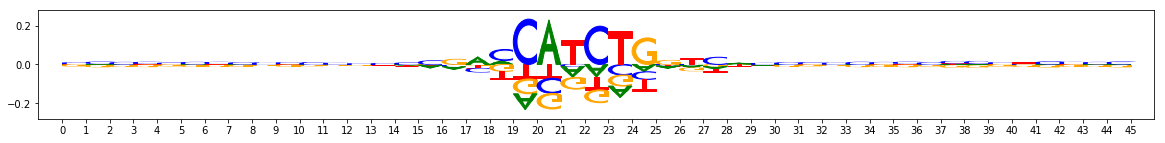

Task 0 actual importance scores:


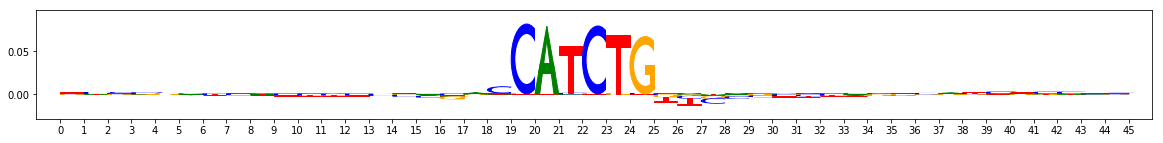

onehot, fwd and rev:


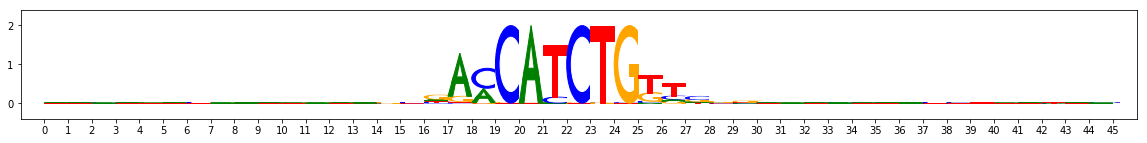

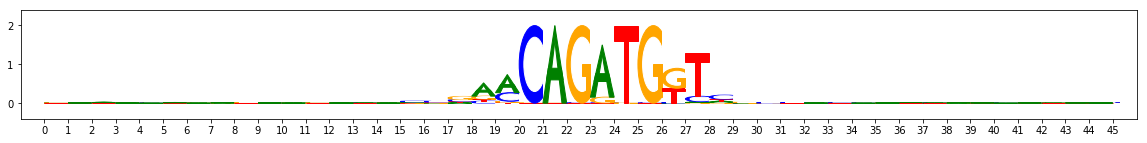

pattern_1
total seqlets: 330
Task 0 hypothetical scores:


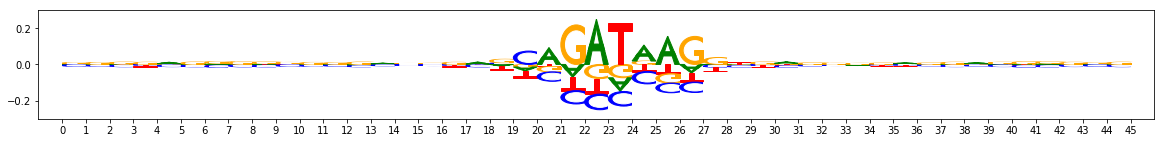

Task 0 actual importance scores:


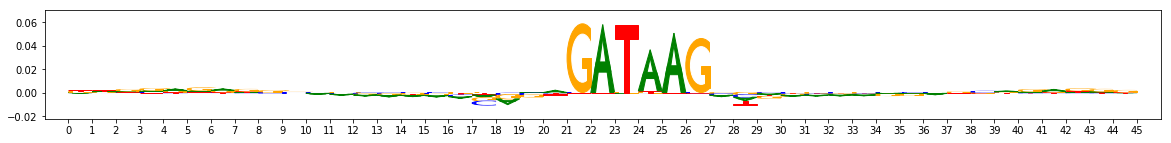

onehot, fwd and rev:


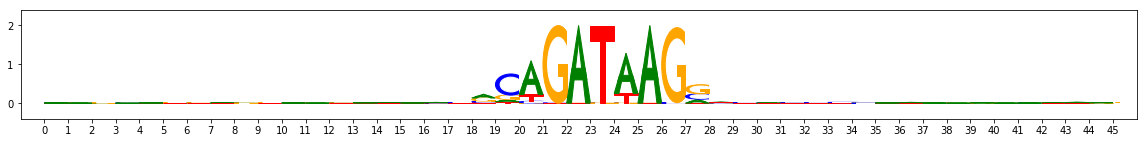

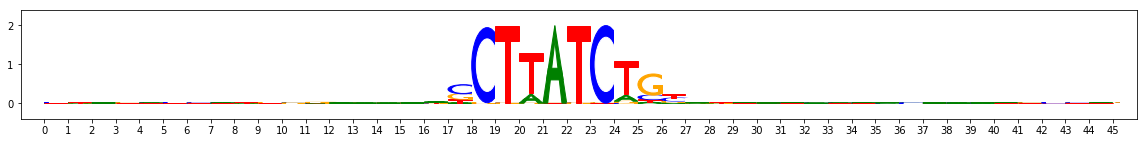

metacluster1
activity pattern: [-1]


In [12]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5")

metacluster_names = list(hdf5_results["metaclustering_results"]["all_metacluster_names"][:])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = (list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:]))
    for pattern_name in all_pattern_names:
        print(pattern_name)
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()